# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading Dataset

In [3]:
path = 'Data/Question4.csv'
df = pd.read_csv(filepath_or_buffer=path)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [6]:
numerical_cols = df.select_dtypes(include=['number']).columns
numerical_cols, len(numerical_cols)

(Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
        'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
        'sqft_living15', 'sqft_lot15'],
       dtype='object'),
 20)

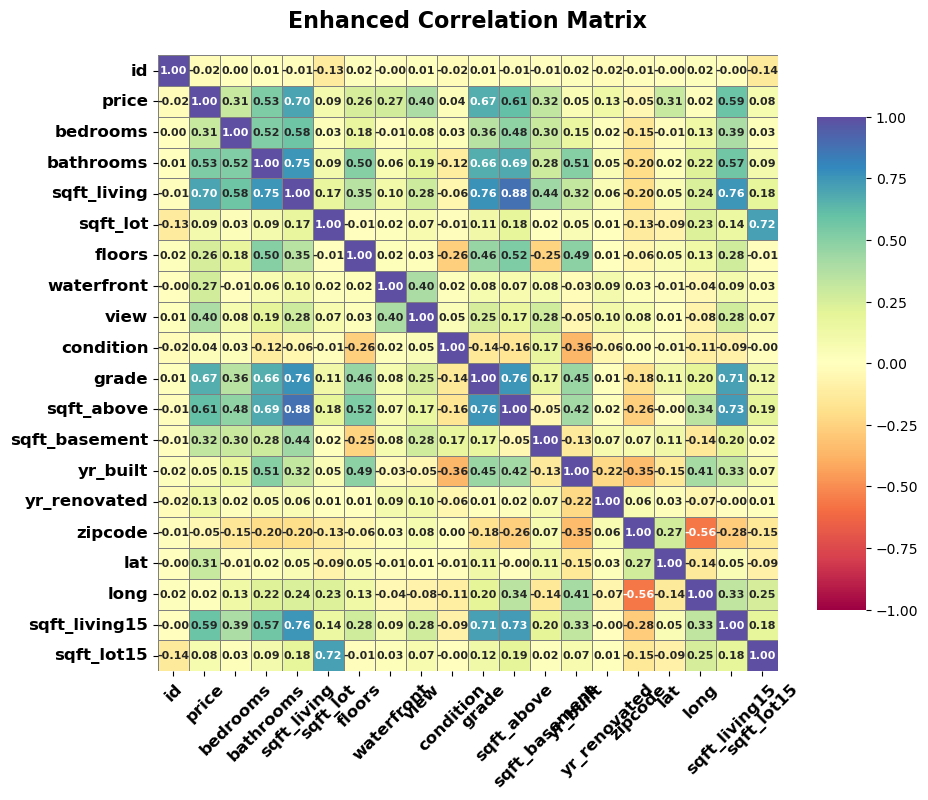

In [7]:
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='Spectral',
    vmin=-1,
    vmax=1,
    center=0,
    annot_kws={"size":8, "weight":"bold"},
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'shrink':0.8, 'aspect':10},
)
plt.title('Enhanced Correlation Matrix', fontsize=16, weight='bold', pad=20)
plt.xticks(fontsize=12, weight='bold', rotation=45)
plt.yticks(fontsize=12, weight='bold', rotation=0)
plt.show()

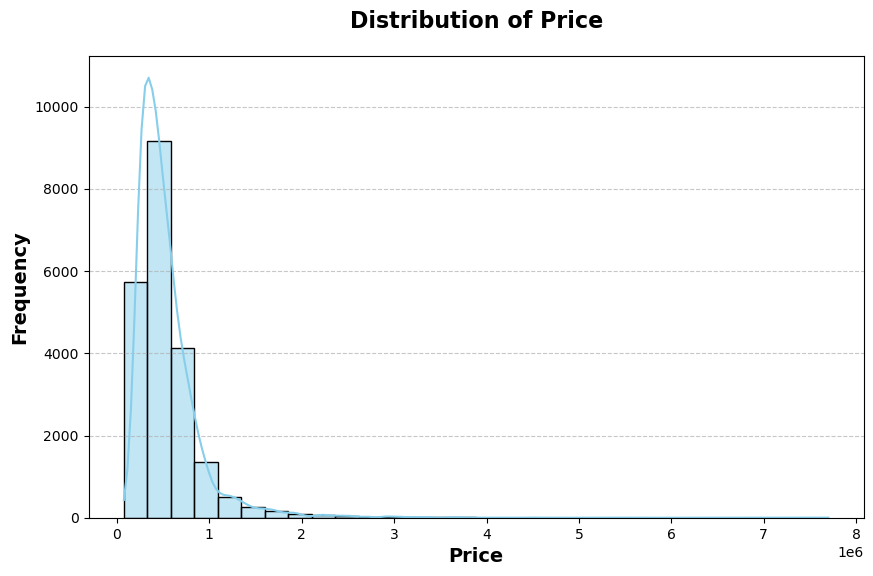

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True, color='skyblue', edgecolor='black', linewidth=1)

plt.title('Distribution of Price', fontsize=16, weight='bold', pad=20)
plt.xlabel('Price', fontsize=14, weight='bold')
plt.ylabel('Frequency', fontsize=14, weight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

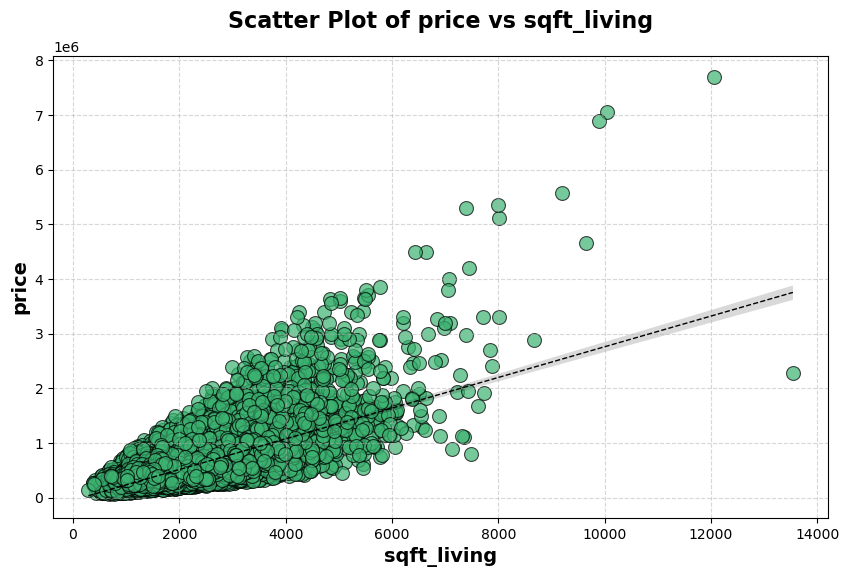

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sqft_living', y='price', s=100, color='mediumseagreen', edgecolor='black', alpha=0.7)

sns.regplot(data=df, x='sqft_living', y='price', scatter=False, color='black', line_kws={'linestyle':'--', 'linewidth':1})

plt.title('Scatter Plot of price vs sqft_living', fontsize=16, weight='bold', pad=20)
plt.xlabel('sqft_living', fontsize=14, weight='bold')
plt.ylabel('price', fontsize=14, weight='bold')

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# Preprocessing
- Change the date
- Split Data
- Standardize 

## Change the date to month and year

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [11]:
df.drop('date', axis=1, inplace=True)

In [12]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2


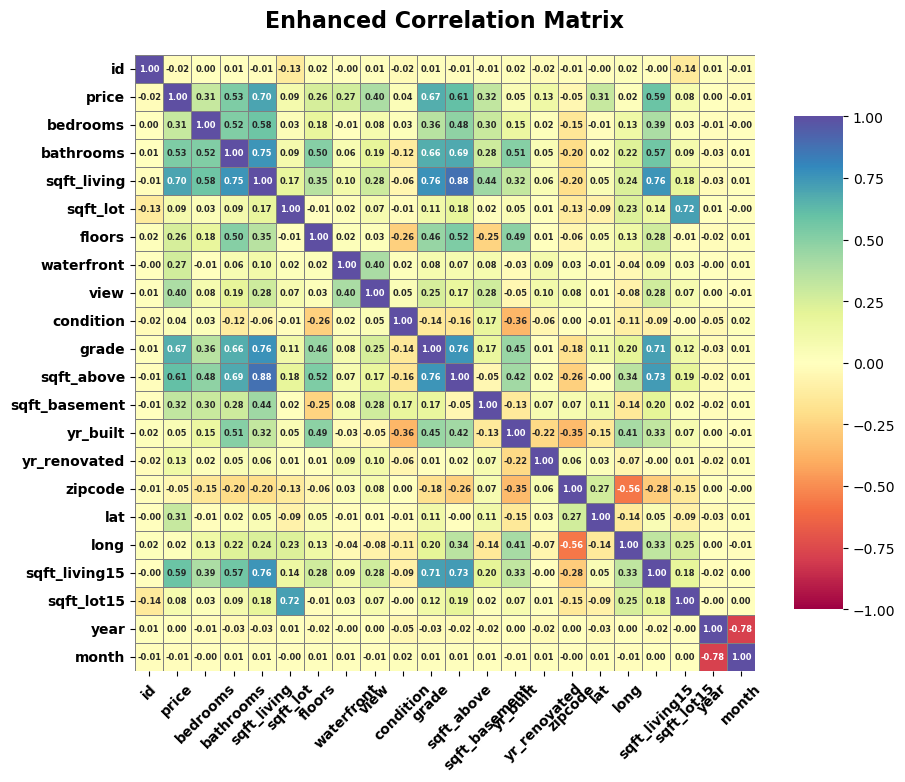

In [13]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='Spectral',
    vmin=-1,
    vmax=1,
    center=0,
    annot_kws={"size":6, "weight":"bold"},
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'shrink':0.8, 'aspect':10},
)
plt.title('Enhanced Correlation Matrix', fontsize=16, weight='bold', pad=20)
plt.xticks(fontsize=10, weight='bold', rotation=45)
plt.yticks(fontsize=10, weight='bold', rotation=0)
plt.show()

## Split dataset

In [14]:
train, val= train_test_split(df, random_state=42, shuffle=True, test_size=0.25)
train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
5945,9117000170,268643.0,4,2.25,1810,9240,2.0,0,0,3,...,0,1961,0,98055,47.4362,-122.187,1660,9240,2015,5
8423,6700390210,245000.0,3,2.50,1600,2788,2.0,0,0,4,...,0,1992,0,98031,47.4034,-122.187,1720,3605,2014,7
13488,7212660540,200000.0,4,2.50,1720,8638,2.0,0,0,3,...,0,1994,0,98003,47.2704,-122.313,1870,7455,2015,1
20731,8562780200,352499.0,2,2.25,1240,705,2.0,0,0,3,...,90,2009,0,98027,47.5321,-122.073,1240,750,2015,4
2358,7760400350,232000.0,3,2.00,1280,13356,1.0,0,0,3,...,0,1994,0,98042,47.3715,-122.074,1590,8071,2014,12


In [15]:
val.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
735,2591820310,365000.0,4,2.25,2070,8893,2.0,0,0,4,...,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,10
2830,7974200820,865000.0,5,3.00,2900,6730,1.0,0,0,5,...,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,8
4106,7701450110,1038000.0,4,2.50,3770,10893,2.0,0,2,3,...,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,8
16218,9522300010,1490000.0,3,3.50,4560,14608,2.0,0,2,3,...,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,3
19964,9510861140,711000.0,3,2.50,2550,5376,2.0,0,0,3,...,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,7


## Scaling

In [16]:
train_standardizer = StandardScaler()
val_standardizer = StandardScaler()

In [17]:
train = train_standardizer.fit_transform(train)
val = val_standardizer.fit_transform(val)

In [18]:
print(f'Mean and varicane of each feature in train set :\n Mean: {train.mean(axis=1)}\n Variance: {train.var(axis=1)}')
print(f'Mean and varicane of each feature in validation set :\n Mean: {val.mean(axis=1)}\n Variance: {val.var(axis=1)}')

Mean and varicane of each feature in train set :
 Mean: [-0.06253269 -0.15435638 -0.19384118 ...  0.08701246 -0.75867873
  0.17243398]
 Variance: [0.42966868 0.33835388 0.75308548 ... 0.39891539 0.80656572 0.76995156]
Mean and varicane of each feature in validation set :
 Mean: [ 0.05251335  0.44577043  0.64792274 ... -0.28140336  0.8072317
 -0.07382541]
 Variance: [0.31905397 0.69256591 1.24269401 ... 0.47751855 1.92628808 0.33565854]


In [19]:
print(type(train), type(val), train.shape, val.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (16209, 22) (5404, 22)


# Implementing one layer
-   Implement a one layer mlp
-   Create a custom dataset with torch
-   Create a dataloader for each train and validation set
-   Define train validation function
-   Evaluate one layer with r2 score and loss per epoch

In [20]:
class one_layer_mlp(nn.Module):
    def __init__(self, neurons:int, dropout:float) -> None:
        super().__init__()
        self.first_layer = nn.Linear(21, neurons)
        self.reg = nn.Linear(neurons, 1)
        self.dropout = nn.Dropout(p=dropout)
        self.actviation = nn.ReLU()
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.dropout(self.actviation(self.first_layer(x)))
        return self.reg(x)

In [21]:
class my_dataset(Dataset):
    def __init__(self, data:np.array, outputs:np.array) -> None:
        self.data = data
        self.outputs = outputs.reshape(-1, 1)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index:int) -> tuple:
        sample = torch.from_numpy(self.data[index]).float()
        output = torch.from_numpy(np.array(self.outputs[index])).float()
        return sample, output

In [22]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2


In [23]:
target_column_index = df.columns.get_loc("price")
X_train = train[:, np.arange(train.shape[1]) != target_column_index]
y_train = train[:, target_column_index]
X_val = val[:, np.arange(val.shape[1]) != target_column_index]
y_val = val[:, target_column_index]
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(16209, 21) (5404, 21) (16209,) (5404,)


In [24]:
train_set = my_dataset(X_train, y_train)
val_set = my_dataset(X_val, y_val)

In [25]:
train_loader = DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
    drop_last=True
)
val_loader= DataLoader(
    val_set,
    batch_size=64,
    shuffle=True,
    drop_last=True
)

In [26]:
for batch_data, batch_labels in train_loader:
    print("Batch data shape:", batch_data.shape)
    print("Batch outputs shape:", batch_labels.shape)
    break

Batch data shape: torch.Size([64, 21])
Batch outputs shape: torch.Size([64, 1])


In [27]:
def validating(dataloader:DataLoader, model:nn.Module, loss_fn):
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            samples, labels = batch[0].to(device), batch[1].to(device)
            preds = model(samples)
            loss = loss_fn(preds, labels)
            val_loss += loss.item()
            all_preds.extend(preds.cpu().detach().numpy())
            all_labels.extend(labels.cpu().numpy())
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)
    print(f'Validation Loss: {val_loss/len(dataloader):.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    return val_loss/len(dataloader), mae, r2

In [28]:
def training(train_loader:DataLoader, validation_loader:DataLoader, optimizer:optim, model:nn.Module, epochs:int, loss_fn):
    model.train()
    training_loss_per_epoch = []
    mae_per_epoch = []
    r2_per_epoch = []
    validation_loss_per_epoch = []
    validation_mea_per_epochs = []
    validation_r2_per_epochs = []
    for epoch in range(epochs):
        training_loss = 0.0
        model.train()
        all_preds = []
        all_labels = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            samples, labels = batch[0].to(device), batch[1].to(device)
            preds = model(samples)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            all_preds.extend(preds.cpu().detach().numpy())
            all_labels.extend(labels.cpu().numpy())
        training_loss = training_loss / len(train_loader)
        training_loss_per_epoch.append(training_loss)
        mae = mean_absolute_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
        mae_per_epoch.append(mae)
        r2_per_epoch.append(r2)
        val_loss, val_mae, val_r2 = validating(validation_loader, model, loss_fn)
        validation_loss_per_epoch.append(val_loss)
        validation_mea_per_epochs.append(val_mae)
        validation_r2_per_epochs.append(val_r2)
    return training_loss_per_epoch, mae_per_epoch, r2_per_epoch, validation_loss_per_epoch ,validation_mea_per_epochs, validation_r2_per_epochs

In [29]:
model_1 = one_layer_mlp(
    neurons=10,
    dropout=0.3
)
model_1.to(device=device)

one_layer_mlp(
  (first_layer): Linear(in_features=21, out_features=10, bias=True)
  (reg): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (actviation): ReLU()
)

In [30]:
loss_fn = nn.MSELoss()

In [31]:
epochs= 40
train_loss, train_mae, train_r2, val_loss ,val_mae, val_r2 = training(
    train_loader=train_loader,
    validation_loader=val_loader,
    optimizer=optim.Adam(params=model_1.parameters(), lr=1e-4, weight_decay=0.0001),
    model=model_1,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.01, MAE: 0.68, R2: -0.01
Validation Loss: 0.92, MAE: 0.63, R2: 0.09


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.87, MAE: 0.62, R2: 0.13
Validation Loss: 0.79, MAE: 0.57, R2: 0.21


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.76, MAE: 0.57, R2: 0.24
Validation Loss: 0.67, MAE: 0.52, R2: 0.33


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.65, MAE: 0.52, R2: 0.35
Validation Loss: 0.57, MAE: 0.47, R2: 0.43


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.56, MAE: 0.48, R2: 0.44
Validation Loss: 0.48, MAE: 0.43, R2: 0.52


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.51, MAE: 0.45, R2: 0.49
Validation Loss: 0.43, MAE: 0.40, R2: 0.57


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.46, MAE: 0.43, R2: 0.54
Validation Loss: 0.39, MAE: 0.38, R2: 0.61


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.43, MAE: 0.41, R2: 0.57
Validation Loss: 0.35, MAE: 0.36, R2: 0.64


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.43, MAE: 0.40, R2: 0.57
Validation Loss: 0.34, MAE: 0.35, R2: 0.66


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.40, MAE: 0.39, R2: 0.60
Validation Loss: 0.33, MAE: 0.34, R2: 0.67


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.40, MAE: 0.39, R2: 0.60
Validation Loss: 0.32, MAE: 0.33, R2: 0.68


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.39, MAE: 0.38, R2: 0.61
Validation Loss: 0.31, MAE: 0.32, R2: 0.69


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.36, MAE: 0.37, R2: 0.64
Validation Loss: 0.30, MAE: 0.32, R2: 0.70


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.36, MAE: 0.37, R2: 0.64
Validation Loss: 0.29, MAE: 0.31, R2: 0.71


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.35, MAE: 0.37, R2: 0.65
Validation Loss: 0.29, MAE: 0.31, R2: 0.72


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.35, MAE: 0.36, R2: 0.65
Validation Loss: 0.28, MAE: 0.31, R2: 0.72


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.34, MAE: 0.36, R2: 0.66
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.35, MAE: 0.36, R2: 0.65
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.33, MAE: 0.36, R2: 0.67
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 20, Training Loss: 0.32, MAE: 0.35, R2: 0.68
Validation Loss: 0.27, MAE: 0.30, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 21, Training Loss: 0.34, MAE: 0.35, R2: 0.66
Validation Loss: 0.26, MAE: 0.29, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 22, Training Loss: 0.33, MAE: 0.35, R2: 0.67
Validation Loss: 0.26, MAE: 0.29, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 23, Training Loss: 0.32, MAE: 0.35, R2: 0.68
Validation Loss: 0.26, MAE: 0.29, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 24, Training Loss: 0.32, MAE: 0.35, R2: 0.68
Validation Loss: 0.25, MAE: 0.29, R2: 0.75


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 25, Training Loss: 0.32, MAE: 0.34, R2: 0.68
Validation Loss: 0.25, MAE: 0.29, R2: 0.75


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 26, Training Loss: 0.32, MAE: 0.35, R2: 0.68
Validation Loss: 0.25, MAE: 0.29, R2: 0.75


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 27, Training Loss: 0.31, MAE: 0.34, R2: 0.69
Validation Loss: 0.25, MAE: 0.29, R2: 0.75


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 28, Training Loss: 0.32, MAE: 0.34, R2: 0.68
Validation Loss: 0.25, MAE: 0.29, R2: 0.75


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 29, Training Loss: 0.31, MAE: 0.34, R2: 0.69
Validation Loss: 0.24, MAE: 0.29, R2: 0.76


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 30, Training Loss: 0.30, MAE: 0.34, R2: 0.70
Validation Loss: 0.24, MAE: 0.29, R2: 0.76


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 31, Training Loss: 0.29, MAE: 0.34, R2: 0.71
Validation Loss: 0.24, MAE: 0.29, R2: 0.76


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 32, Training Loss: 0.31, MAE: 0.34, R2: 0.69
Validation Loss: 0.24, MAE: 0.28, R2: 0.76


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 33, Training Loss: 0.31, MAE: 0.34, R2: 0.69
Validation Loss: 0.24, MAE: 0.28, R2: 0.76


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 34, Training Loss: 0.30, MAE: 0.34, R2: 0.70
Validation Loss: 0.24, MAE: 0.28, R2: 0.76


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 35, Training Loss: 0.31, MAE: 0.34, R2: 0.69
Validation Loss: 0.24, MAE: 0.28, R2: 0.76


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 36, Training Loss: 0.30, MAE: 0.34, R2: 0.70
Validation Loss: 0.23, MAE: 0.28, R2: 0.77


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 37, Training Loss: 0.29, MAE: 0.34, R2: 0.71
Validation Loss: 0.23, MAE: 0.28, R2: 0.77


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 38, Training Loss: 0.29, MAE: 0.33, R2: 0.70
Validation Loss: 0.23, MAE: 0.28, R2: 0.77


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 39, Training Loss: 0.31, MAE: 0.34, R2: 0.69
Validation Loss: 0.23, MAE: 0.28, R2: 0.77


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 40, Training Loss: 0.30, MAE: 0.33, R2: 0.70
Validation Loss: 0.23, MAE: 0.28, R2: 0.77


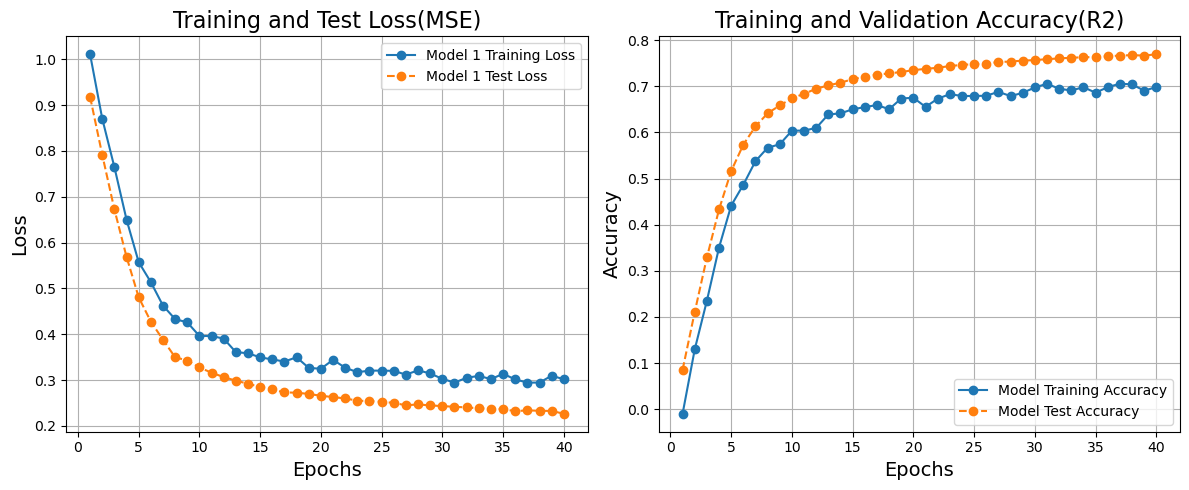

In [32]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Model 1 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, val_loss, label='Model 1 Test Loss', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Test Loss(MSE)', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_r2, label='Model Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, val_r2, label='Model Test Accuracy', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy(R2)', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Implementing two layer MPL
-   Implement model
-   Train the model
-   Evaluate this model's result

In [33]:
class two_layer_mlp(nn.Module):
    def __init__(self, n_neurons_first:int, n_neurons_second:int, dropout:float) -> None:
        super().__init__()
        self.layer1 = nn.Linear(21, n_neurons_first)
        self.layer2 = nn.Linear(n_neurons_first, n_neurons_second)
        self.reg = nn.Linear(n_neurons_second, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        return self.reg(x)

In [34]:
model_2 = two_layer_mlp(
    n_neurons_first=10,
    n_neurons_second=5,
    dropout=0.3
)
model_2.to(device=device)

two_layer_mlp(
  (layer1): Linear(in_features=21, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=5, bias=True)
  (reg): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [35]:
epochs= 50
train_loss_2, train_mae_2, train_r2_2, val_loss_2 ,val_mae_2, val_r2_2 = training(
    train_loader=train_loader,
    validation_loader=val_loader,
    optimizer=optim.Adam(params=model_2.parameters(), lr=1e-4, weight_decay=0.0001),
    model=model_2,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.99, MAE: 0.59, R2: 0.01
Validation Loss: 0.95, MAE: 0.56, R2: 0.05


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.93, MAE: 0.57, R2: 0.07
Validation Loss: 0.86, MAE: 0.53, R2: 0.14


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.84, MAE: 0.55, R2: 0.16
Validation Loss: 0.76, MAE: 0.51, R2: 0.24


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.77, MAE: 0.54, R2: 0.23
Validation Loss: 0.67, MAE: 0.49, R2: 0.33


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.73, MAE: 0.52, R2: 0.27
Validation Loss: 0.60, MAE: 0.47, R2: 0.40


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.66, MAE: 0.51, R2: 0.34
Validation Loss: 0.54, MAE: 0.44, R2: 0.46


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.66, MAE: 0.50, R2: 0.34
Validation Loss: 0.50, MAE: 0.42, R2: 0.51


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.60, MAE: 0.48, R2: 0.40
Validation Loss: 0.45, MAE: 0.40, R2: 0.54


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.59, MAE: 0.47, R2: 0.41
Validation Loss: 0.43, MAE: 0.39, R2: 0.57


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.56, MAE: 0.46, R2: 0.44
Validation Loss: 0.40, MAE: 0.38, R2: 0.60


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.51, MAE: 0.45, R2: 0.49
Validation Loss: 0.38, MAE: 0.36, R2: 0.62


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.51, MAE: 0.45, R2: 0.49
Validation Loss: 0.36, MAE: 0.36, R2: 0.64


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.51, MAE: 0.44, R2: 0.49
Validation Loss: 0.35, MAE: 0.35, R2: 0.65


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.51, MAE: 0.43, R2: 0.49
Validation Loss: 0.34, MAE: 0.34, R2: 0.66


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.49, MAE: 0.42, R2: 0.51
Validation Loss: 0.34, MAE: 0.34, R2: 0.66


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.47, MAE: 0.42, R2: 0.53
Validation Loss: 0.33, MAE: 0.34, R2: 0.67


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.50, MAE: 0.42, R2: 0.50
Validation Loss: 0.32, MAE: 0.33, R2: 0.68


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.48, MAE: 0.42, R2: 0.52
Validation Loss: 0.32, MAE: 0.33, R2: 0.68


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.45, MAE: 0.41, R2: 0.55
Validation Loss: 0.32, MAE: 0.33, R2: 0.68


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 20, Training Loss: 0.47, MAE: 0.41, R2: 0.53
Validation Loss: 0.31, MAE: 0.32, R2: 0.69


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 21, Training Loss: 0.48, MAE: 0.41, R2: 0.52
Validation Loss: 0.31, MAE: 0.32, R2: 0.69


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 22, Training Loss: 0.46, MAE: 0.41, R2: 0.54
Validation Loss: 0.31, MAE: 0.32, R2: 0.70


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 23, Training Loss: 0.43, MAE: 0.41, R2: 0.57
Validation Loss: 0.30, MAE: 0.32, R2: 0.70


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 24, Training Loss: 0.48, MAE: 0.41, R2: 0.52
Validation Loss: 0.30, MAE: 0.31, R2: 0.70


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 25, Training Loss: 0.47, MAE: 0.41, R2: 0.53
Validation Loss: 0.30, MAE: 0.31, R2: 0.70


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 26, Training Loss: 0.45, MAE: 0.41, R2: 0.55
Validation Loss: 0.29, MAE: 0.31, R2: 0.71


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 27, Training Loss: 0.45, MAE: 0.40, R2: 0.55
Validation Loss: 0.29, MAE: 0.31, R2: 0.71


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 28, Training Loss: 0.45, MAE: 0.40, R2: 0.55
Validation Loss: 0.29, MAE: 0.31, R2: 0.71


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 29, Training Loss: 0.43, MAE: 0.40, R2: 0.57
Validation Loss: 0.28, MAE: 0.31, R2: 0.72


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 30, Training Loss: 0.44, MAE: 0.40, R2: 0.56
Validation Loss: 0.28, MAE: 0.30, R2: 0.72


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 31, Training Loss: 0.44, MAE: 0.40, R2: 0.56
Validation Loss: 0.28, MAE: 0.30, R2: 0.72


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 32, Training Loss: 0.45, MAE: 0.40, R2: 0.55
Validation Loss: 0.28, MAE: 0.30, R2: 0.72


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 33, Training Loss: 0.46, MAE: 0.40, R2: 0.54
Validation Loss: 0.28, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 34, Training Loss: 0.43, MAE: 0.39, R2: 0.57
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 35, Training Loss: 0.42, MAE: 0.39, R2: 0.58
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 36, Training Loss: 0.44, MAE: 0.39, R2: 0.56
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 37, Training Loss: 0.44, MAE: 0.40, R2: 0.56
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 38, Training Loss: 0.43, MAE: 0.39, R2: 0.57
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 39, Training Loss: 0.43, MAE: 0.39, R2: 0.57
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 40, Training Loss: 0.41, MAE: 0.39, R2: 0.59
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 41, Training Loss: 0.42, MAE: 0.39, R2: 0.58
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 42, Training Loss: 0.42, MAE: 0.39, R2: 0.58
Validation Loss: 0.27, MAE: 0.30, R2: 0.73


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 43, Training Loss: 0.42, MAE: 0.39, R2: 0.58
Validation Loss: 0.26, MAE: 0.29, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 44, Training Loss: 0.41, MAE: 0.39, R2: 0.59
Validation Loss: 0.26, MAE: 0.30, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 45, Training Loss: 0.41, MAE: 0.39, R2: 0.59
Validation Loss: 0.26, MAE: 0.29, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 46, Training Loss: 0.42, MAE: 0.39, R2: 0.58
Validation Loss: 0.25, MAE: 0.29, R2: 0.75


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 47, Training Loss: 0.38, MAE: 0.38, R2: 0.62
Validation Loss: 0.25, MAE: 0.29, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 48, Training Loss: 0.44, MAE: 0.39, R2: 0.56
Validation Loss: 0.25, MAE: 0.29, R2: 0.74


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 49, Training Loss: 0.42, MAE: 0.39, R2: 0.58
Validation Loss: 0.25, MAE: 0.29, R2: 0.75


  0%|          | 0/253 [00:00<?, ?it/s]

Epoch 50, Training Loss: 0.45, MAE: 0.39, R2: 0.55
Validation Loss: 0.26, MAE: 0.29, R2: 0.74


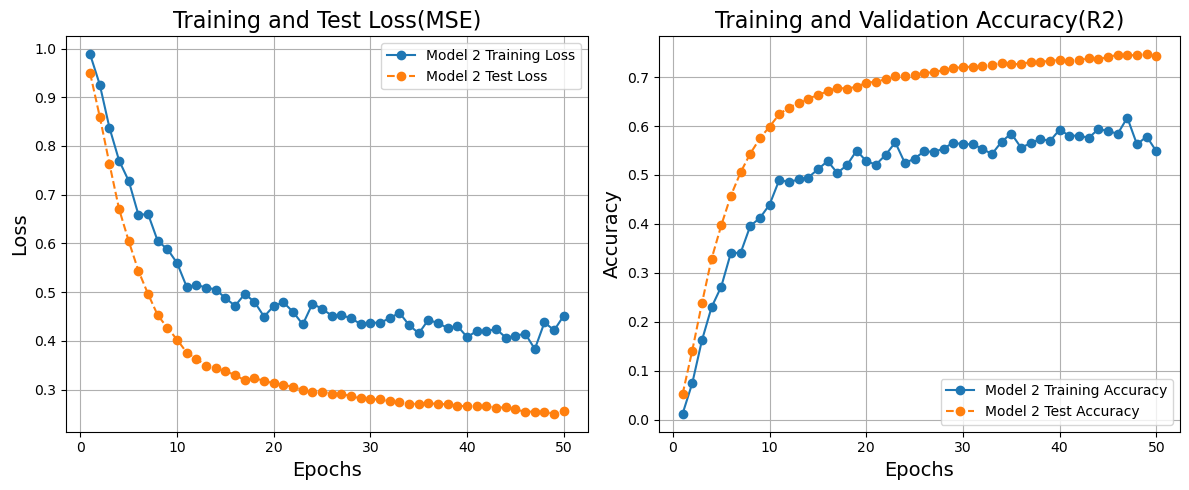

In [36]:
epochs = range(1, len(train_loss_2) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_2, label='Model 2 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, val_loss_2, label='Model 2 Test Loss', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Test Loss(MSE)', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_r2_2, label='Model 2 Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, val_r2_2, label='Model 2 Test Accuracy', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy(R2)', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Five random sample from val set

In [51]:
random.seed(3)
n_samples = 5
random_indices = random.sample(range(len(val_set)), n_samples)
random_indices

[1949, 4854, 4458, 1068, 3030]

In [52]:
random_samples = [val_set[i] for i in random_indices]

In [53]:
outputs = []
model_1_output = []
model_2_output = []
for i, (sample, output) in enumerate(random_samples):
    outputs.append(output.item())
    model_1_output.append(model_1(sample.to(device)).item())
    model_2_output.append(model_2(sample.to(device)).item())

In [54]:
df = pd.DataFrame({
    'True Outputs': outputs,
    'Prediction Model 1': model_1_output,
    'Prediction Model 2': model_2_output
})

In [55]:
df.head()

,True Outputs,Prediction Model 1,Prediction Model 2
0,-0.666916,-0.538922,-0.457573
1,1.140354,1.917813,1.468383
2,0.840457,0.727009,0.583553
3,-0.123952,0.082203,0.084364
4,-0.744483,-0.535236,-0.434024


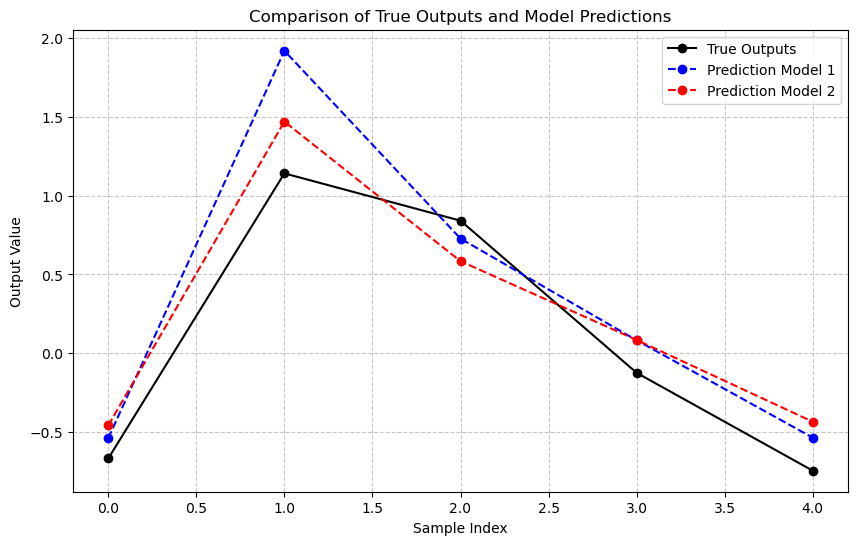

In [56]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['True Outputs'], marker='o', label='True Outputs', color='black', linestyle='-')
plt.plot(df.index, df['Prediction Model 1'], marker='o', label='Prediction Model 1', color='blue', linestyle='--')
plt.plot(df.index, df['Prediction Model 2'], marker='o', label='Prediction Model 2', color='red', linestyle='--')

plt.xlabel('Sample Index')
plt.ylabel('Output Value')
plt.title('Comparison of True Outputs and Model Predictions')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()